The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install mxnet-cu100
!pip install https://tvm-repo.s3-us-west-2.amazonaws.com/cuda10.0-llvm6.0/tvm-0.6.dev0-cp36-cp36m-linux_x86_64.whl https://tvm-repo.s3-us-west-2.amazonaws.com/cuda10.0-llvm6.0/topi-0.6.dev0-py3-none-any.whl
!pip install git+https://github.com/d2l-ai/d2l-tvm


# Broadcast Add

:label:`ch_bcast_add_gpu`


This section talks about scheduling the broadcast add computation defined in :numref:`ch_bcast_add` on GPU. Similar to the CPU case, we can extend what we have done for vector add on GPU in :numref:`ch_vector_add_gpu` with some minor modification.

## Setup

In [1]:
%matplotlib inline
import tvm
import numpy as np
import d2ltvm
import mxnet as mx
import timeit 

Like :numref:`ch_vector_add_gpu`, we use MXNet as our baseline. The following code block plots the performance baseline as a function of consumed data size. The broadcast pattern is the same as :numref:`fig_bcast_add` illustrates.

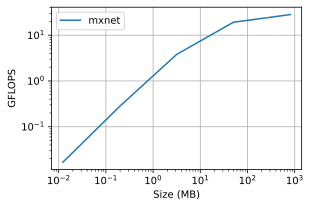

In [2]:
sizes = 2**np.arange(5, 15, 2)

mx_bcast_add = lambda s1, s2: timeit.Timer(
    setup='import mxnet as mx\n'
    'import d2ltvm\n'
    'mx_arr = lambda x: mx.nd.array(x, ctx=mx.gpu())\n'
    'a, b, c = d2ltvm.get_bcast_data(%s, %s, mx_arr)' % (s1, s2),
    stmt='mx.nd.broadcast_add(a, b, out=c); c.wait_to_read()')

exe_times = [d2ltvm.bench_workload(mx_bcast_add((n, 1), (n, n)).timeit) for n in sizes]
mx_gflops = sizes * sizes / 1e9 / np.array(exe_times)
# data size in MB
x_axis_sizes = (sizes * sizes * 2 + sizes * sizes) * 4 / 1e6
d2ltvm.plot_gflops(x_axis_sizes, [mx_gflops], ['mxnet'], xlabel='Size (MB)')

## Continuous scheduling

Like in :numref:`ch_vector_add_gpu`, we will need to bind some axes to CUDA threads and blocks. For broadcast add depicted in :numref:`fig_bcast_add`, the loop pattern is straightforward, where the inner loop goes through the columns of a particular row of `B`, and the outer loop goes through all rows. One way to think about the thread binding could be to bind the CUDA threads along column axis `y` and blocks along row axis `x`. However, when the number of columns exceeds 1024, it will return an error as violating the maximal number of threads in a block. Therefore, we will need to restrict the number of threads as `nt`. There is no constraint on the number of blocks (`nb`), but generally, we want one thread to take care of multiple calculations if the processed data is large to reduce the overhead.

We first specify `nt` and `nb`.

In [3]:
nt = 64  # number of threads in a block
nb = 256 # number of blocks

with tvm.target.create('cuda'):
    assert nt <= tvm.target.current_target(allow_none=False).max_num_threads, \
        'the number of threads in a block exceed the hardware limit'

To facilitate the splitting and binding, we can first fuse the two loops of broadcast add together. Then we bind the threads accordingly. Note that we only further split the data to let one thread process multiple calculations when the data size is large enough, i.e. `need_further_split=True`.

In [4]:
def continuous_parallel(n):
    A, B, C = d2ltvm.broadcast_add((n,1), (n,n))
    total_size = n * n
    need_further_split = total_size > nb * nt
    s = tvm.create_schedule(C.op)
    x, y = C.op.axis
    fused = s[C].fuse(x, y)
    if need_further_split:
        bx, tx = s[C].split(fused, nparts=nb)
        tx, xi = s[C].split(tx, nparts=nt)
        s[C].bind(bx, tvm.thread_axis("blockIdx.x"))
        s[C].bind(tx, tvm.thread_axis("threadIdx.x"))
    else:
        bx, tx = s[C].split(fused, factor=nt)
        s[C].bind(bx, tvm.thread_axis("blockIdx.x"))
        s[C].bind(tx, tvm.thread_axis("threadIdx.x"))
    return s, (A, B, C)

s, args = continuous_parallel(256)
tvm.lower(s, args, simple_mode=True)

produce C {
  // attr [iter_var(blockIdx.x, , blockIdx.x)] thread_extent = 256
  // attr [iter_var(threadIdx.x, , threadIdx.x)] thread_extent = 64
  for (x.y.fused.inner.inner, 0, 4) {
    C[(((blockIdx.x*256) + (threadIdx.x*4)) + x.y.fused.inner.inner)] = (A[blockIdx.x] + B[(((blockIdx.x*256) + (threadIdx.x*4)) + x.y.fused.inner.inner)])
  }
}

The pseudo-code above looks reasonable. Each thread works on a number of calculations over a continuous data chunk. Now let's compile it to execute.

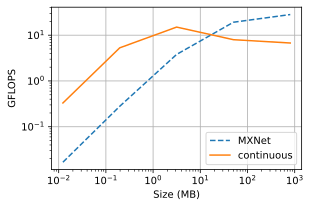

In [5]:
mod = tvm.build(s, args, 'cuda')

tvm_continuous_gflops = d2ltvm.bench_bcast_add_tvm(continuous_parallel, sizes, 'cuda')
d2ltvm.plot_gflops(x_axis_sizes, [mx_gflops, tvm_continuous_gflops], 
                   ['MXNet', 'continuous'], xlabel='Size (MB)')

We see that the continuous scheduling outperforms MXNet only for small workloads due to lighter overhead. Its performance becomes inferior to MXNet while increasing the data size. This is because the continuous scheduling causes serious bank conflict, which we will discuss in :numref:`ch_conv_gpu` and solve it in a more systematic way.

## Alternate scheduling
For now, let's try to avoid one thread processing a continuous data chunk. Instead, we make each thread operate on the scattered data. :numref:`fig_bcast_add_gpu` depicts the difference between continuous and alternate schedulings.

![Difference between continuous and alternate schedulings.](http://tvm.d2l.ai/_images/bcast_add_gpu.svg)

:label:`fig_bcast_add_gpu`

In [6]:
def alternate_parallel(n):
    A, B, C = d2ltvm.broadcast_add((n,1), (n,n))
    total_size = n * n
    need_further_split = total_size > nb * nt
    s = tvm.create_schedule(C.op)
    x, y = C.op.axis
    fused = s[C].fuse(x, y)
    if need_further_split:
        xo, xi = s[C].split(fused, factor=nb * nt)
        bx, tx = s[C].split(xi, factor=nt)
        # bring the outermost axis to the innermost 
        # for alternate data access of a CUDA thread
        s[C].reorder(bx, tx, xo)
        s[C].bind(bx, tvm.thread_axis("blockIdx.x"))
        s[C].bind(tx, tvm.thread_axis("threadIdx.x"))
    else:
        bx, tx = s[C].split(fused, factor=nt)
        s[C].bind(bx, tvm.thread_axis("blockIdx.x"))
        s[C].bind(tx, tvm.thread_axis("threadIdx.x"))
    return s, (A, B, C)

s, args = alternate_parallel(256)
tvm.lower(s, args, simple_mode=True)

produce C {
  // attr [iter_var(blockIdx.x, , blockIdx.x)] thread_extent = 256
  // attr [iter_var(threadIdx.x, , threadIdx.x)] thread_extent = 64
  for (x.y.fused.outer, 0, 4) {
    C[(((x.y.fused.outer*16384) + (blockIdx.x*64)) + threadIdx.x)] = (A[((x.y.fused.outer*64) + floordiv(((blockIdx.x*64) + threadIdx.x), 256))] + B[(((x.y.fused.outer*16384) + (blockIdx.x*64)) + threadIdx.x)])
  }
}

Comparing with the pseudo-code above, we can easily see that the data access changes. Now let's compile it to execute.

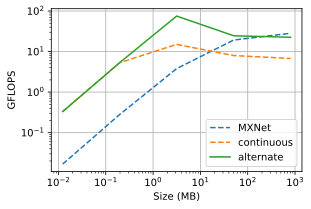

In [7]:
mod = tvm.build(s, args, 'cuda')

tvm_alternate_gflops = d2ltvm.bench_bcast_add_tvm(alternate_parallel, sizes, 'cuda')
d2ltvm.plot_gflops(x_axis_sizes, [mx_gflops, tvm_continuous_gflops, tvm_alternate_gflops], 
                   ['MXNet', 'continuous', 'alternate'], xlabel='Size (MB)')

The performance is much better than continuous scheduling once `need_further_split=True`. We also observe that the performance drops notably after the data size exceeds the L2 cache size (6 MB) shared by all SMs.

Lastly, it is worthwhile to note that the two values `nt` and `nb` are tunable based on the workload and platform. It is not guaranteed that what we have chosen here is best for all cases we tested out. And there is no combination which works well across all cases. Therefore, a good compiler will need to allow tuning on this kind of parameters.

## Summary

- It is favorable for CUDA threads to access data alternately.

## Exercise

- Vary `nt` and `nb` to observe the performance difference.
- Try to schedule other broadcast add patterns and observe the difference.